# Multilayer perceptron classifier for news sentiment

The financial news sentiment dataset has about 4846 records of financial news and corresponinding sentiment. The sentiments include 'positive', 'neutral' and 'negative'. 
The below code will load, precess data and use the mulilayer perceptron .

### Create a spark session and load the Financial News Data set

In [0]:
from pyspark.sql import SparkSession

In [0]:
spark = SparkSession.builder.appName('FinancialNewsDL').getOrCreate()

In [0]:
#spark.conf.set("spark.sql.legacy.timeParserPolicy","LEGACY")

file_location = "/FileStore/tables/FinancialNewsSentiment.csv"
file_type = "csv"

# CSV options
infer_schema = "true"
first_row_is_header = "false"
delimiter = ","

df_news = spark.read.format(file_type) \
  .option("inferSchema", infer_schema) \
  .option("header", first_row_is_header) \
  .option("sep", delimiter) \
  .load(file_location)\

#end loading

In [0]:
display (df_news)

_c0,_c1
neutral,"According to Gran , the company has no plans to move all production to Russia , although that is where the company is growing ."
neutral,"Technopolis plans to develop in stages an area of no less than 100,000 square meters in order to host companies working in computer technologies and telecommunications , the statement said ."
negative,"The international electronic industry company Elcoteq has laid off tens of employees from its Tallinn facility ; contrary to earlier layoffs the company contracted the ranks of its office workers , the daily Postimees reported ."
positive,With the new production plant the company would increase its capacity to meet the expected increase in demand and would improve the use of raw materials and therefore increase the production profitability .
positive,"According to the company 's updated strategy for the years 2009-2012 , Basware targets a long-term net sales growth in the range of 20 % -40 % with an operating profit margin of 10 % -20 % of net sales ."
positive,FINANCING OF ASPOCOMP 'S GROWTH Aspocomp is aggressively pursuing its growth strategy by increasingly focusing on technologically more demanding HDI printed circuit boards PCBs .
positive,"For the last quarter of 2010 , Componenta 's net sales doubled to EUR131m from EUR76m for the same period a year earlier , while it moved to a zero pre-tax profit from a pre-tax loss of EUR7m ."
positive,"In the third quarter of 2010 , net sales increased by 5.2 % to EUR 205.5 mn , and operating profit by 34.9 % to EUR 23.5 mn ."
positive,Operating profit rose to EUR 13.1 mn from EUR 8.7 mn in the corresponding period in 2007 representing 7.7 % of net sales .
positive,"Operating profit totalled EUR 21.1 mn , up from EUR 18.6 mn in 2007 , representing 9.7 % of net sales ."


In [0]:
df_news = df_news.withColumnRenamed("_c0","label")
df_news = df_news.withColumnRenamed("_c1","news")

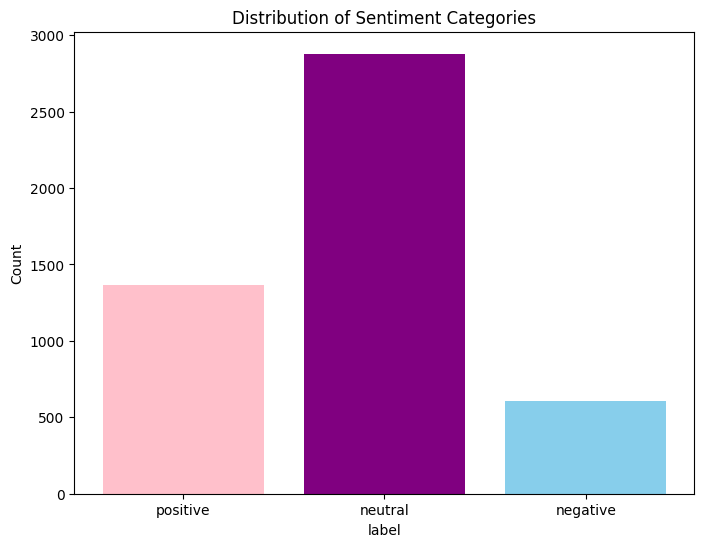

In [0]:
import matplotlib.pyplot as plt

# Group by sentiment and count the occurrences
sentiment_counts = df_news.groupBy('label').count().collect()

# Extract sentiment categories and counts
sentiments = [row['label'] for row in sentiment_counts]
counts = [row['count'] for row in sentiment_counts]

# Plotting
plt.figure(figsize=(8, 6))
plt.bar(sentiments, counts, color=['pink', 'purple', 'skyblue'])
plt.xlabel('label')
plt.ylabel('Count')
plt.title('Distribution of Sentiment Categories')
plt.show()

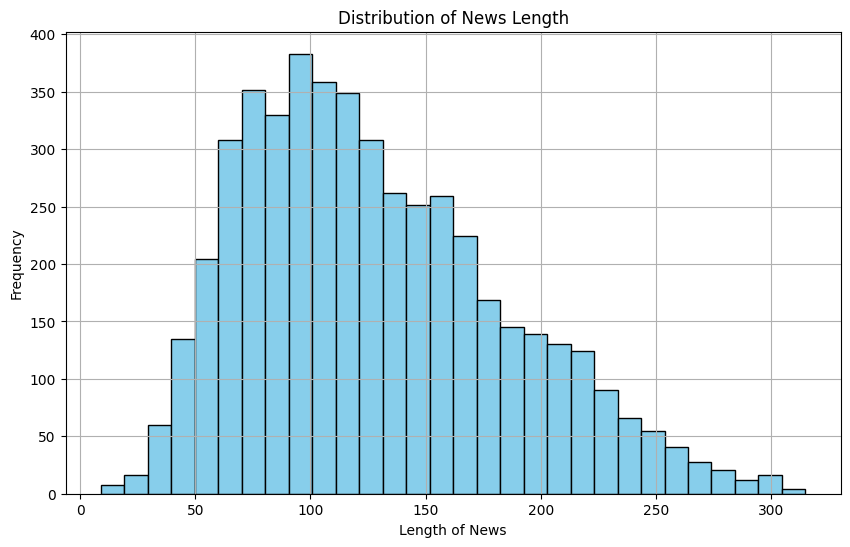

Descriptive Statistics for News Length:
  summary         news_length
0   count                4846
1    mean   128.1320676846884
2  stddev  56.526179541123554
3     min                   9
4     max                 315


In [0]:
from pyspark.sql.functions import length

# Calculate the length of each news article
df_news = df_news.withColumn('news_length', length('news'))

# descriptive analysis
length_stats = df_news.select('news_length').describe().toPandas()

# Visualize the distribution of news length using a histogram
plt.figure(figsize=(10, 6))
plt.hist(df_news.select('news_length').rdd.flatMap(lambda x: x).collect(), bins=30, color='skyblue', edgecolor='black')
plt.xlabel('Length of News')
plt.ylabel('Frequency')
plt.title('Distribution of News Length')
plt.grid(True)
plt.show()

# descriptive statistics
print("Descriptive Statistics for News Length:")
print(length_stats)


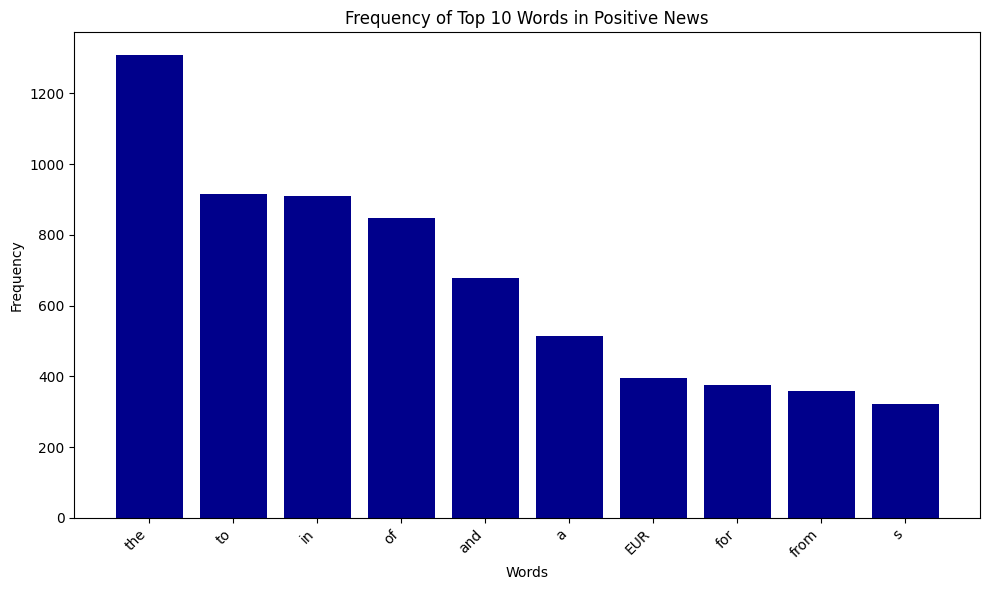

In [0]:
from pyspark.sql.functions import explode, split, desc, regexp_extract
import matplotlib.pyplot as plt

# Filter the rows with positive sentiment
positive_df = df_news.filter(df_news['label'] == 'positive')

# Split the news text into words and explode into rows
positive_words_df = positive_df.withColumn('word', explode(split(positive_df['news'], ' ')))

# Remove punctuation from words
positive_words_df = positive_words_df.withColumn('word', regexp_extract('word', r'(\w+)', 0))

# Filter out empty strings
positive_words_df = positive_words_df.filter(positive_words_df['word'] != '')

# Count
word_counts_df = positive_words_df.groupBy('word').count()

# top 10 most frequent words
top_10_words_df = word_counts_df.orderBy(desc('count')).limit(10)

# Convert DataFrame to Pandas for visualization
top_10_words_pd = top_10_words_df.toPandas()

# Visualization
plt.figure(figsize=(10, 6))
plt.bar(top_10_words_pd['word'], top_10_words_pd['count'], color='darkblue')
plt.xlabel('Words')
plt.ylabel('Frequency')
plt.title('Frequency of Top 10 Words in Positive News')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()


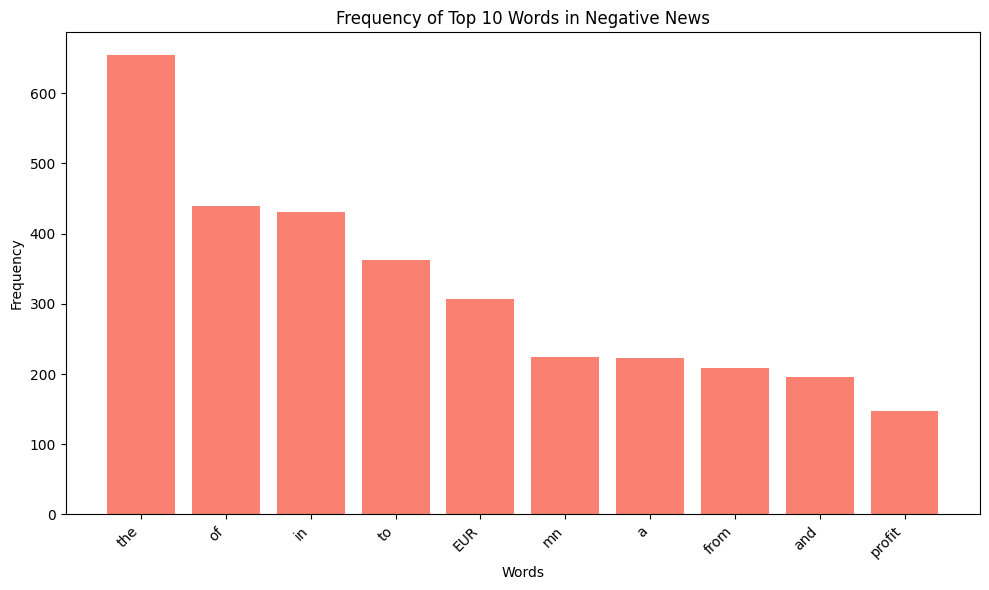

In [0]:
# Filter the rows with negative sentiment
negative_df = df_news.filter(df_news['label'] == 'negative')

# Split the news text into words and explode into rows
negative_words_df = negative_df.withColumn('word', explode(split(negative_df['news'], ' ')))

# Remove punctuation from words
negative_words_df = negative_words_df.withColumn('word', regexp_extract('word', r'(\w+)', 0))

# Filter out empty strings
negative_words_df = negative_words_df.filter(negative_words_df['word'] != '')

# Count
word_counts_df = negative_words_df.groupBy('word').count()

# top 10 most frequent words
top_10_words_df = word_counts_df.orderBy(desc('count')).limit(10)

# Convert DataFrame to Pandas for visualization
top_10_words_pd = top_10_words_df.toPandas()

# Visualization
plt.figure(figsize=(10, 6))
plt.bar(top_10_words_pd['word'], top_10_words_pd['count'], color='salmon')
plt.xlabel('Words')
plt.ylabel('Frequency')
plt.title('Frequency of Top 10 Words in Negative News')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()


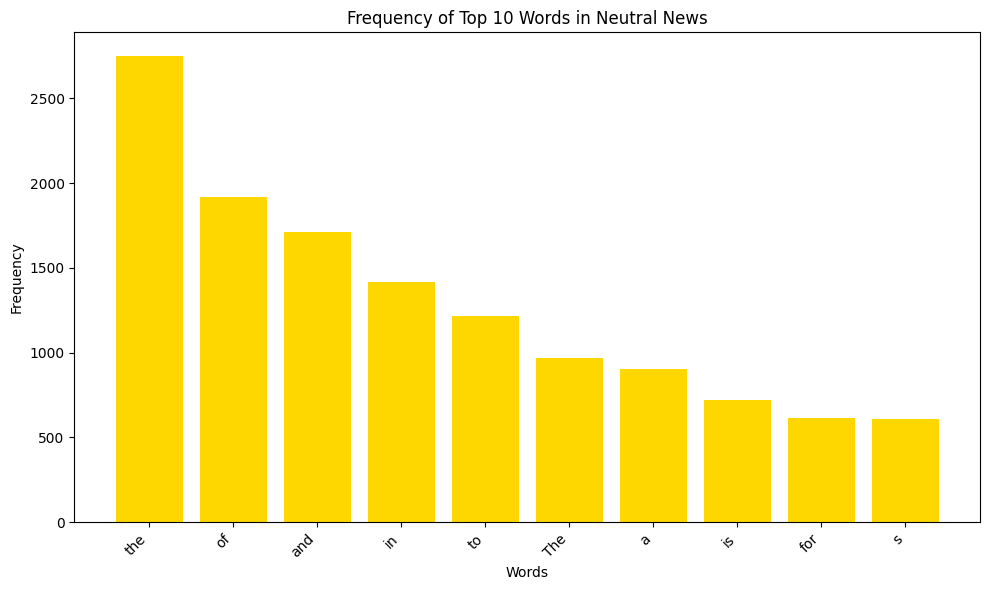

In [0]:
# Filter the rows with negative sentiment
neutral_df = df_news.filter(df_news['label'] == 'neutral')

# Split the news text into words and explode into rows
neutral_words_df = neutral_df.withColumn('word', explode(split(neutral_df['news'], ' ')))

# Remove punctuation from words
neutral_words_df = neutral_words_df.withColumn('word', regexp_extract('word', r'(\w+)', 0))

# Filter out empty strings 
neutral_words_df = neutral_words_df.filter(neutral_words_df['word'] != '')

# Count 
word_counts_df = neutral_words_df.groupBy('word').count()

# top 10 most frequent words
top_10_words_df = word_counts_df.orderBy(desc('count')).limit(10)

# Convert DataFrame to Pandas for visualization
top_10_words_pd = top_10_words_df.toPandas()

# Visualization
plt.figure(figsize=(10, 6))
plt.bar(top_10_words_pd['word'], top_10_words_pd['count'], color='gold')
plt.xlabel('Words')
plt.ylabel('Frequency')
plt.title('Frequency of Top 10 Words in Neutral News')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

### Data processing

In [0]:
df_news = df_news.dropna()

In [0]:
# Create a 70-30 train test split

train_data,test_data=df_news.randomSplit([0.7,0.3])

### Building the MultiLayerPerceptron model

In [0]:
import pyspark.sql.functions as f

In [0]:
# Index label column as it is category variable - positive, negative, neutral
from pyspark.ml.feature import StringIndexer
labelIndexer = StringIndexer(inputCol="label",outputCol="indexedLabel")
#labelIndexer = labelIndexer.fit(df_news)

In [0]:
from pyspark.ml.feature import HashingTF, IDF, Tokenizer

tokenizer = Tokenizer(inputCol="news", outputCol="words")

hashingTF = HashingTF(inputCol="words", outputCol="rawFeatures", numFeatures= 4000)

idf = IDF(inputCol="rawFeatures", outputCol="features")

In [0]:
# Import the required libraries
from pyspark.ml.classification import MultilayerPerceptronClassifier

In [0]:
# Create an object for the MultilayerPerception model

layers = [4000,128,64,3]
mlpModel = MultilayerPerceptronClassifier(maxIter=50, layers= layers, seed=1984, blockSize=128, featuresCol="features", labelCol= "indexedLabel")

In [0]:
# Pipeline is used to pass the data through indexer, tokenizer, TF-IDF simultaneously. Also, it helps to pre-rocess the test data in the same way as that of the train data. It also 
from pyspark.ml import Pipeline

pipe = Pipeline(stages=[labelIndexer,tokenizer,hashingTF,idf,mlpModel])


In [0]:
fit_model=pipe.fit(train_data)

In [0]:
# Store the results in a dataframe

result = fit_model.transform(test_data)

In [0]:
result.select("indexedLabel","prediction").show()

+------------+----------+
|indexedLabel|prediction|
+------------+----------+
|         2.0|       1.0|
|         2.0|       2.0|
|         2.0|       2.0|
|         2.0|       1.0|
|         2.0|       2.0|
|         2.0|       1.0|
|         2.0|       0.0|
|         2.0|       0.0|
|         2.0|       1.0|
|         2.0|       0.0|
|         2.0|       0.0|
|         2.0|       2.0|
|         2.0|       2.0|
|         2.0|       2.0|
|         2.0|       2.0|
|         2.0|       1.0|
|         2.0|       0.0|
|         2.0|       2.0|
|         2.0|       2.0|
|         2.0|       2.0|
+------------+----------+
only showing top 20 rows



### Evaluating the model

##### Accuracy

In [0]:
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
pred_and_actual = result.select("prediction","indexedLabel").withColumnRenamed("indexedLabel","label")
evaluator = MulticlassClassificationEvaluator(metricName="accuracy")
print("The accuracy of the model is {}".format(evaluator.evaluate(pred_and_actual)))
#print(str(evaluator.evaluate(pred_and_actual)))

The accuracy of the model is 0.718728403593642


##### Confusion Matrix

In [0]:
from pyspark.sql.types import FloatType
from pyspark.mllib.evaluation import MulticlassMetrics
#important: need to cast to float type, and order by prediction, else it won't work
pred_and_actual = result.select(['prediction','indexedLabel']).withColumn('label', f.col('indexedLabel').cast(FloatType())).orderBy('prediction')

#select only prediction and label columns
pred_and_actual = pred_and_actual.select(['prediction','label'])

metrics = MulticlassMetrics(pred_and_actual.rdd.map(tuple))

#print(metrics.confusionMatrix().toArray())
print("Below is the confusion matrix \n {}".format(metrics.confusionMatrix().toArray()))

/databricks/spark/python/pyspark/sql/context.py:165: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  warnings.warn(


Below is the confusion matrix 
 [[702. 117.  32.]
 [152. 246.  17.]
 [ 51.  38.  92.]]


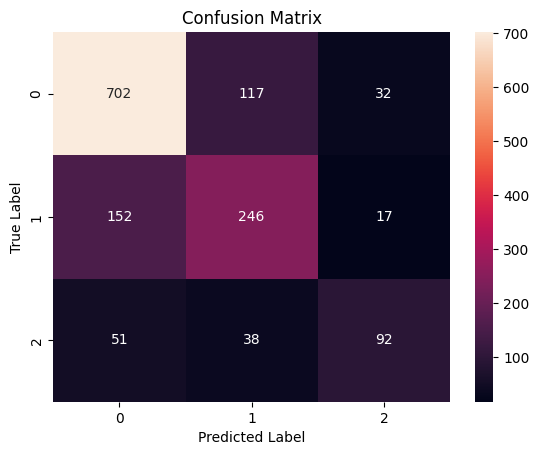

In [0]:
# Confusion Matrix Visualization
import seaborn as sns
import matplotlib.pyplot as plt

conf_matrix = metrics.confusionMatrix().toArray()
sns.heatmap(conf_matrix, annot=True, fmt='g')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

#####  Area under the ROC

In [0]:
from pyspark.ml.evaluation import BinaryClassificationEvaluator
AUC_evaluator = BinaryClassificationEvaluator(rawPredictionCol='prediction',labelCol='indexedLabel',metricName='areaUnderROC')
AUC = AUC_evaluator.evaluate(result)
print("The area under the curve is {}".format(AUC))

The area under the curve is 0.7457669224520699


A roughly 75% area under ROC denotes the model has performed reasonably well in predicting the sentiment of financial news

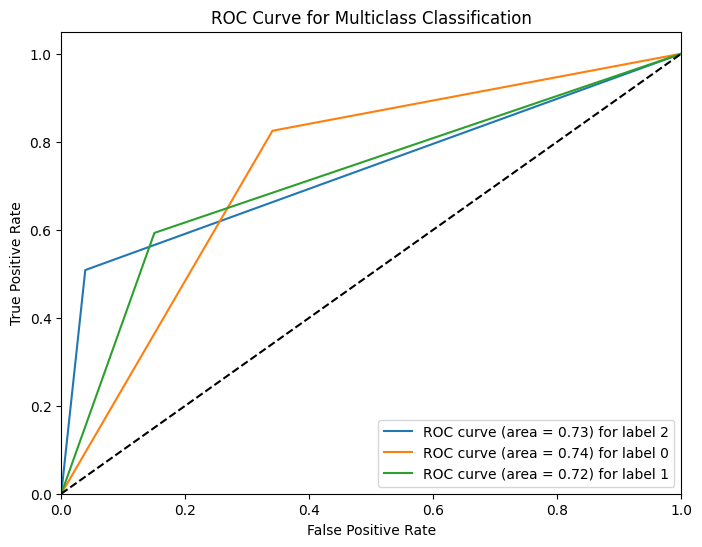

In [0]:
 from sklearn.metrics import roc_curve, auc

# Convert DataFrame to Pandas DataFrame
pred_and_actual_pd = pred_and_actual.toPandas()

# Compute ROC curve and AUC for each class
fpr = dict()
tpr = dict()
roc_auc = dict()

# Get unique labels
labels = pred_and_actual_pd['label'].unique()

for label in labels:
 # Create binary labels for each class
    y_true = (pred_and_actual_pd['label'] == label).astype(int)
    y_score = pred_and_actual_pd['prediction'].apply(lambda x: 1 if x == label else 0)

    # Compute ROC curve
    fpr[label], tpr[label], _ = roc_curve(y_true, y_score)
    
    # Compute AUC
    roc_auc[label] = auc(fpr[label], tpr[label])

# Plot ROC curves for each class
plt.figure(figsize=(8, 6))

for label in labels:
    plt.plot(fpr[label], tpr[label], label='ROC curve (area = %0.2f) for label %d' % (roc_auc[label], label))

plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Multiclass Classification')
plt.legend(loc="lower right")
plt.show()

#####  Area under the PR

In [0]:
PR_evaluator = BinaryClassificationEvaluator(rawPredictionCol='prediction',labelCol='indexedLabel',metricName='areaUnderPR')
PR = PR_evaluator.evaluate(result)
print("The area under the PR curve is {}".format(PR))

The area under the PR curve is 0.6919495306905559


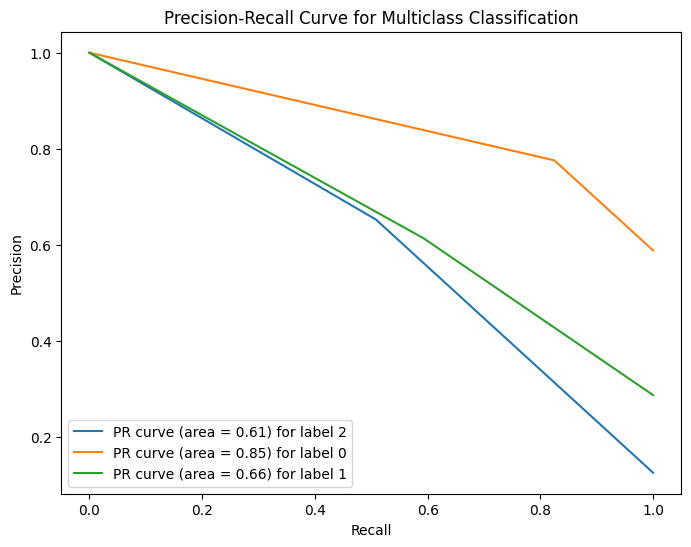

In [0]:
from sklearn.metrics import precision_recall_curve

# Convert DataFrame to Pandas DataFrame
pred_and_actual_pd = pred_and_actual.toPandas()

# Compute precision-recall curve and AUC for each class
precision = dict()
recall = dict()
pr_auc = dict()

# Get unique labels
labels = pred_and_actual_pd['label'].unique()

for label in labels:
    # Create binary labels for each class
    y_true = (pred_and_actual_pd['label'] == label).astype(int)
    y_score = pred_and_actual_pd['prediction'].apply(lambda x: 1 if x == label else 0)

    # Compute precision-recall curve
    precision[label], recall[label], _ = precision_recall_curve(y_true, y_score)
    
    # Compute AUC for precision-recall curve
    pr_auc[label] = auc(recall[label], precision[label])

# Plot precision-recall curves for each class
plt.figure(figsize=(8, 6))

for label in labels:
    plt.plot(recall[label], precision[label], label='PR curve (area = %0.2f) for label %d' % (pr_auc[label], label))

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve for Multiclass Classification')
plt.legend(loc="lower left")
plt.show()


### Save Model

In [0]:
#set / load basePath
basePath = "/FileStore/finalproject"

##### Save the pipeline

In [0]:
pipe.write().overwrite().save(basePath + "/pipeline")

##### Save trained model (pipeline)

In [0]:
fit_model.write().overwrite().save(basePath + "/model")

### Load Model for new prediction

In [0]:
#Load / set basePath
basePath = "/FileStore/finalproject"

##### Load the pipeline

In [0]:
from pyspark.ml import Pipeline
pipe_new = Pipeline.load(basePath + "/pipeline")

##### Load the trained model (pipeline)

In [0]:
from pyspark.ml import PipelineModel
load_fit_model = PipelineModel.load(basePath + "/model")

##### Test Loading trained model. To be removed in the product

In [0]:
new_result = load_fit_model.transform(test_data)

In [0]:
pred_and_actual = new_result.select("prediction","indexedLabel").withColumnRenamed("indexedLabel","label")
evaluator = MulticlassClassificationEvaluator(metricName="accuracy")
print("The accuracy of the model is {}".format(evaluator.evaluate(pred_and_actual)))

The accuracy of the model is 0.718728403593642


In [0]:
pred_and_actual = new_result.select(['prediction','indexedLabel']).withColumn('label', f.col('indexedLabel').cast(FloatType())).orderBy('prediction')

#select only prediction and label columns
pred_and_actual = pred_and_actual.select(['prediction','label'])

metrics = MulticlassMetrics(pred_and_actual.rdd.map(tuple))

#print(metrics.confusionMatrix().toArray())
print("Below is the confusion matrix \n {}".format(metrics.confusionMatrix().toArray()))

/databricks/spark/python/pyspark/sql/context.py:165: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  warnings.warn(


Below is the confusion matrix 
 [[702. 117.  32.]
 [152. 246.  17.]
 [ 51.  38.  92.]]
